# Binary Target Boosting with Custom Model Callback Wrapper

This example will demonstrate the following uses of the library:

1. Supervised learning with a binary target
2. Wrapping a custom model callback to perform CV at each boosting iteration
3. Interchanging link and loss function

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scst

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.datasets import make_classification

from genestboost import BoostedModel
from genestboost.link_functions import LogitLink, CLogLogLink
from genestboost.loss_functions import LogLoss, LeakyBetaLoss

%matplotlib inline

### Create a dummy classification dataset

In [2]:
X, y = make_classification(n_samples=20000,
                           n_features=50,
                           n_informative=20,
                           weights=(0.85, 0.15),
                           random_state=11)
X = scale(X)

### Create a Custom Model Wrapper

Here, let's create a custom model wrapper that will allow us to perform a 3-fold cross-validation over decision tree hyperparameters at each model iteration. We just need to make sure that we provide a callback that returns a model with a fit and predict method. `GridSearchCV` has a fit method, and after the fit we can simply take the best returned model.

In [3]:
# model_callback
class CVDecisionTree:
    def __init__(self, param_grid, folds=3, n_jobs=-1):
        self._param_grid = param_grid   # parameter grid for CV
        self._folds = folds             # number of CV folds to use in grid search
        self._n_jobs = n_jobs           # number of jobs to use
        self._model = None
                
    def fit(self, X, y, weights=None):
        new_model = GridSearchCV(
            estimator=DecisionTreeRegressor(splitter="random", random_state=17),
            param_grid = self._param_grid,
            cv=self._folds,
            n_jobs = self._n_jobs,
            refit=True,
        )
        new_model.fit(X, y, weights)
        new_model = new_model.best_estimator_   # refit=True to get the best estimator
        self._model = new_model
        
        # new model should have a predict method, but we will implement our own
        return self
    
    def predict(self, X):
        return self._model.predict(X)

# create param_grid for model_callback kwargs
param_grid = {
      'min_samples_split': [10, 20, 50],
      "max_depth": [2, 3, 5],
}

# model_callback_kwargs
model_callback_kwargs = {"param_grid": param_grid}

### Fit the model using LogitLink and LogLoss

First, let's fit a model for the binary target using the same link/loss function as ordinary logistic regression.

In [4]:
with warnings.catch_warnings():  # catch sklearn utils warning
    warnings.simplefilter("ignore")
    
    # fit model
    model = BoostedModel(
        link=LogitLink(),
        loss=LogLoss(),
        weights="newton",
        alpha=2.0,
        step_type="decaying",
        validation_fraction=0.30,
        validation_stratify=True,
        validation_iter_stop=20,
        model_callback=CVDecisionTree,                 # use our customer wrapper
        model_callback_kwargs=model_callback_kwargs,   # with our param grid
    )
    model.fit(X, y, iterations=500)
    preds = model.predict(X)

print("Number of model iterations: {:d}".format(model.get_iterations()))

Number of model iterations: 500


### Plot the loss history

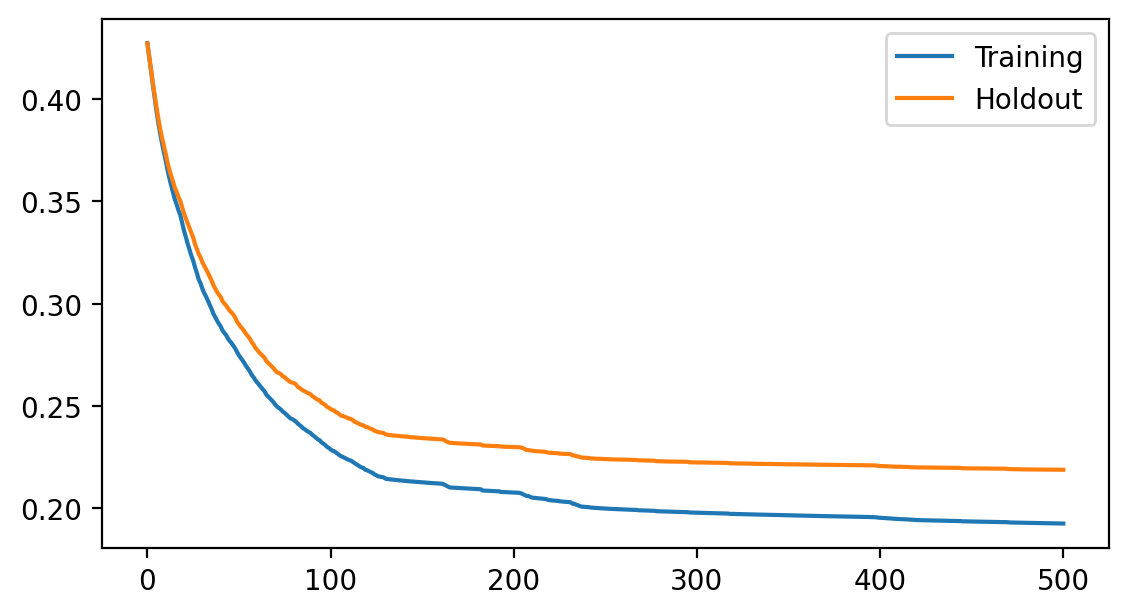

In [5]:
fig = plt.figure(figsize=(6.5, 3.5), dpi=200)
ax = fig.add_subplot(111)
ax.plot(model.get_loss_history(), label=["Training", "Holdout"])
ax.legend(loc="best");

### Try a Different Link and Loss Pair

To demonstrate how easy it is to switch the link and loss function, let's refit the model with CLogLogLink and BetaLoss functions.

In [6]:
with warnings.catch_warnings():  # catch sklearn utils warning
    warnings.simplefilter("ignore")
    
    # fit model
    model = BoostedModel(
        link=CLogLogLink(),
        loss=LeakyBetaLoss(alpha=5.0, beta=5.0),
        weights="none",
        alpha=1.0,
        step_type="decaying",
        validation_fraction=0.30,
        validation_stratify=True,
        validation_iter_stop=20,
        model_callback=CVDecisionTree,                 # use our customer wrapper
        model_callback_kwargs=model_callback_kwargs,   # with our param grid
    )
    model.fit(X, y, iterations=500)
    preds = model.predict(X)

print("Number of model iterations: {:d}".format(model.get_iterations()))

Number of model iterations: 500


### Plot the loss history again for CLogLog and LeakyBetaLoss

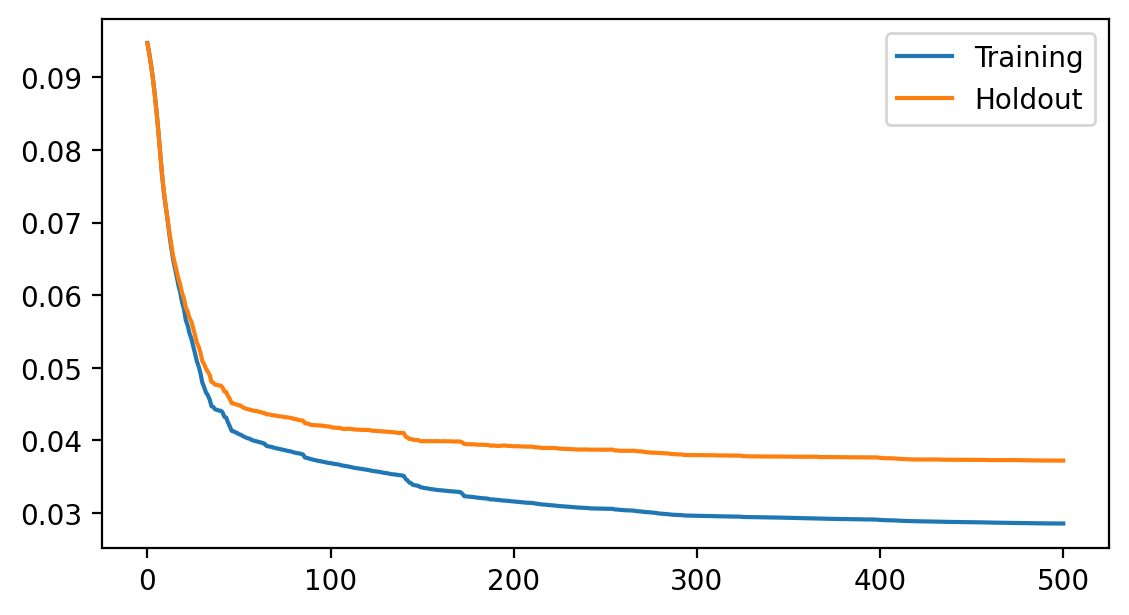

In [7]:
fig = plt.figure(figsize=(6.5, 3.5), dpi=200)
ax = fig.add_subplot(111)
ax.plot(model.get_loss_history(), label=["Training", "Holdout"])
ax.legend(loc="best");